# Fmrate prediction

In [86]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## Split data

In [71]:
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=42, shuffle=True):
    assert val_size + test_size < 1, "There's no training examples, need some training examples" 
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=random_state, 
                                                        shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=val_size/(1-test_size), 
                                                      random_state=random_state,
                                                      shuffle=shuffle) 
    # 1/4 = 20/80 = 0.2/(0.2+0.6)
    # Reset indices of df:
    X_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [72]:
data_df = pd.read_csv("../data/fmrate_dataset.csv")

In [73]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [74]:
X = data_df.drop(columns=[f"rate[{i}]" for i in range(12)])
y = data_df[[f"rate[{i}]" for i in range(12)]]

In [75]:
X

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [76]:
y

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,56941.760321,1264.897761,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,58123.694878,1296.198799,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,58244.963030,1278.068894,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,58325.603325,1293.320262,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,57655.444528,1226.298473,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...
64677,166768.282730,3383.497463,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,201208.113638,3954.093915,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,168499.665785,3143.015693,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,157398.392828,2854.361729,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [77]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y,
                                                                      val_size=0.2,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      shuffle=True)

In [78]:
[el.shape for el in [X_train, X_val, X_test, y_train, y_val, y_test]]

[(38808, 17), (12937, 17), (12937, 17), (38808, 12), (12937, 12), (12937, 12)]

**We're not allowed to use the test set to make any decision !!**

## Preprocessing

- https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
- https://youtu.be/juEOOQntrd0

In [89]:
estimator = MLPRegressor(random_state=42, max_iter=500)
pipe = make_pipeline(StandardScaler(), estimator)

In [90]:
pipe.fit(X_train, y_train)

/home/zenchiyu/.local/share/virtualenvs/POLAR-background-prediction-g2F1Og_3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor(max_iter=500, random_state=42))])

In [93]:
pred = pipe.predict(X_test)
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,41355.964441,1163.523906,8.287445,0.454291,0.148902,141211.015402,38673.250876,10544.650956,6291.084464,1877.609923,196055.233627,8910.568378
1,44015.745821,831.357102,12.967627,2.005760,-0.067958,134473.197001,35207.910077,10949.685843,6644.317798,1891.442337,203539.756617,8987.964607
2,68808.618719,1563.037012,13.064774,2.184649,-0.335377,175202.092931,46176.120059,12247.613771,7237.624289,2088.592004,283093.085368,10785.614635
3,50014.918672,949.734962,8.453743,0.916921,-0.146745,130397.001314,34368.561029,9215.559163,5443.703153,1583.620417,207816.268639,8012.382358
4,129621.346207,3017.861617,18.780708,3.435826,-0.586886,291466.572608,79417.431373,19282.186790,11142.250560,3166.351162,503529.460097,17788.576829
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,51983.039256,897.319826,8.588867,1.011936,-0.063407,127165.620954,32621.886053,8648.967148,5185.960395,1551.833900,207219.002682,7666.740116
12933,115510.908341,2394.549747,18.216742,3.358656,-0.583813,261849.731218,69952.000146,16564.549932,9379.645946,2501.908620,447071.453208,15279.684586
12934,45336.492202,949.886937,9.802240,0.919332,0.109590,115825.622655,29889.802260,8089.970295,4871.273717,1470.174964,190634.233270,7160.032052
12935,52695.547638,1263.888536,8.945558,1.297908,-0.326847,144841.789052,38725.400656,10308.268805,6233.921795,1955.023049,226797.676335,9039.662742


In [92]:
y_test

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,39666.714593,866.404998,10.082507,3.105673,0.000000,122033.702955,31147.553468,8729.637997,5250.500931,1494.047199,175130.958662,7242.826666
1,39206.905346,937.616185,7.585328,0.000000,0.000000,127310.713049,37572.890825,11432.578881,6884.149169,2072.683404,181600.743510,9363.210896
2,58828.753158,1252.327510,11.585707,2.804762,0.000000,158229.622928,41202.144571,10809.537605,6314.589655,1789.866461,248118.176833,9447.769862
3,48597.201879,1093.953563,7.858231,0.000000,0.000000,131715.016775,35017.780701,9212.419084,5329.005555,1475.518841,200701.631459,7920.319116
4,113504.590523,1920.732754,17.406818,1.169180,0.000000,224828.597760,63501.637430,17283.222397,10135.516266,2810.431277,423391.947171,15798.092607
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,48669.541767,1020.041537,6.781120,0.000000,0.000000,142719.829902,41410.097310,12574.622647,7794.778101,2491.062487,216000.653750,10776.246841
12933,150032.812672,2343.673268,17.322014,2.749030,0.000000,270312.046198,69083.354281,17480.121508,9859.572819,2655.876876,519302.680819,16576.421467
12934,43574.112208,932.081493,13.609812,7.937698,2.875306,125832.180583,33883.334715,9027.958346,5302.678262,1519.200869,190604.767699,7762.557712
12935,53414.522625,1114.832045,14.230360,2.001162,0.000000,141965.890735,37146.646473,10098.887138,6164.919025,1951.718759,222480.227041,9012.415159


## Visualization

Let's only look at `rate[0]`

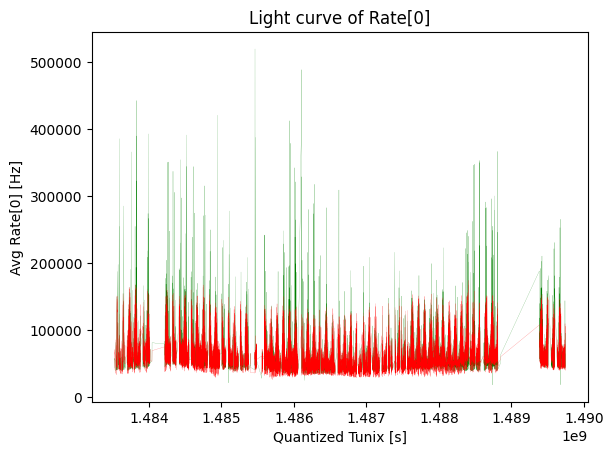

In [126]:
argsort = np.argsort(X_test["unix_time"])[::-1]
sorted_time_test = X_test["unix_time"][argsort]
sorted_y_test_r0 = y_test.loc[:, "rate[0]"][argsort]
sorted_pred_r0 = pred[:, 0][argsort]

plt.plot(sorted_time_test, sorted_y_test_r0, '-g', linewidth=0.1)
plt.plot(sorted_time_test, sorted_pred_r0, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]")
plt.show()

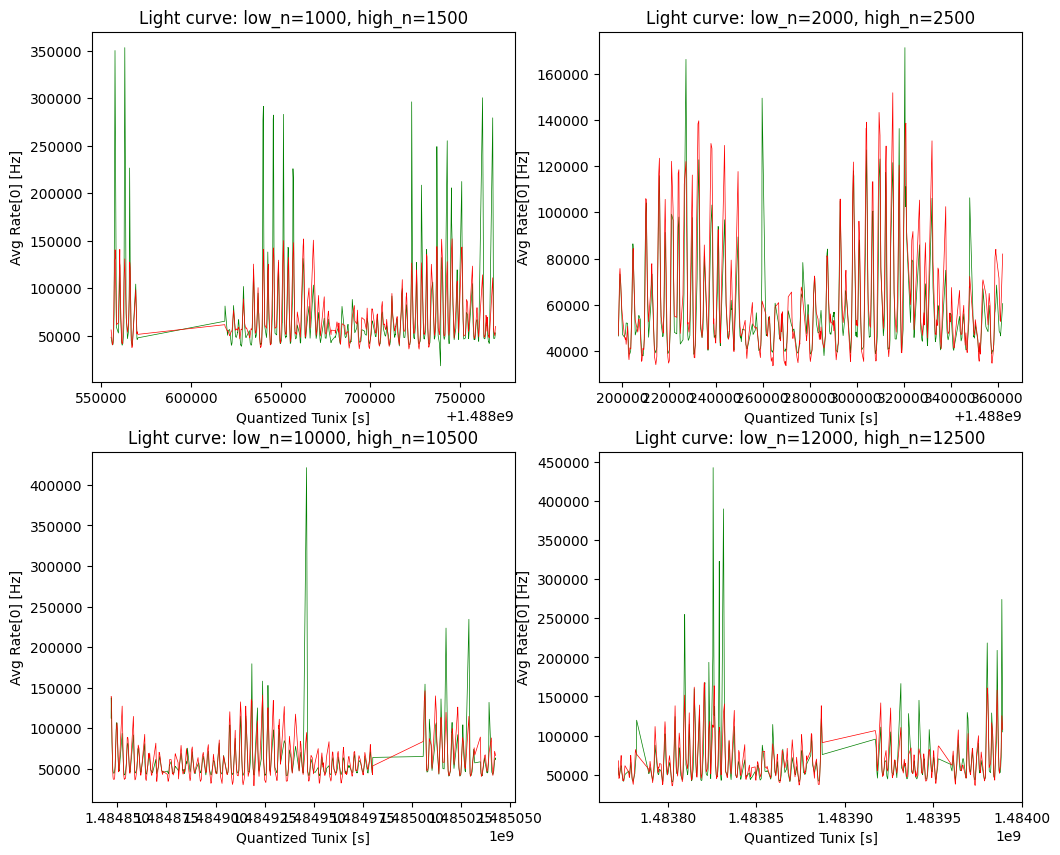

In [131]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1500), (2000, 2500),
                                   (10000, 10500), (12000, 12500)]):
    axs[i//2, i%2].plot(sorted_time_test[low_n:high_n], sorted_y_test_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_test[low_n:high_n], sorted_pred_r0[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve: low_n={low_n}, high_n={high_n}")
plt.show()

In [146]:
fitted_mlp = pipe["mlpregressor"]

In [147]:
np.sqrt(fitted_mlp.loss_), np.std(sorted_y_test_r0)

(22591.484504967106, 33245.95319625567)

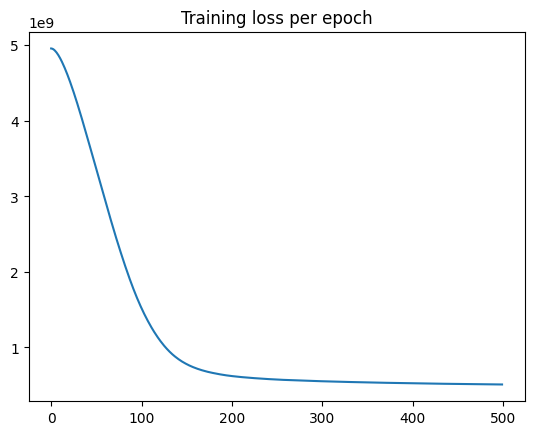

In [148]:
plt.plot(fitted_mlp.loss_curve_)
plt.title("Training loss per epoch")
plt.show()

In [149]:
fitted_mlp.coefs_

[array([[-24.84652561,  -6.18902101,  13.77769757, ...,  -2.05508579,
         -17.46298678, -14.05622783],
        [-28.5994442 ,  18.98400287,  22.02177053, ...,   9.1819516 ,
          14.40723862,  13.03583855],
        [ 16.96623059, -24.52367411, -19.32446158, ..., -24.89902173,
         -19.7827835 , -20.91868049],
        ...,
        [-26.39193832,   8.10543173,   6.55563887, ...,   8.67995803,
           2.84231003,   3.90339749],
        [ 43.87007751,  18.33947575,  12.15846459, ...,  21.22131892,
          23.77934367,  22.95269289],
        [-10.98238221,  -0.94912894,  -5.22561692, ...,   1.77220068,
           4.09476582,   1.70024315]]),
 array([[ 7.21310005e+00,  3.39628055e-01, -1.29960214e-02, ...,
          1.12030018e+00,  4.13504631e+01,  3.23121121e+00],
        [ 5.39442960e+00, -4.15176836e-02, -3.44673809e-02, ...,
          5.33877684e-01,  2.53938844e+01,  1.84325195e+00],
        [ 1.13045071e+01,  5.95955599e-01,  3.05028584e-02, ...,
          1.54731295

**TODO: try compare it with linear regression only using `fe_cosmic`**